In [1]:
grand_prix = "Bahrain"

safety_car_laps = []  # FORMAT: list of safety cars, start lap to resume lap (i.e. first non-safety car lap)

In [2]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.dates as mdates
from matplotlib import font_manager
from matplotlib.ticker import FixedLocator

import seaborn as sns
from sklearn.linear_model import LinearRegression

from timple.timedelta import strftimedelta
from datetime import datetime, timedelta


import fastf1 as f1
import fastf1.plotting
from fastf1.core import Laps
from fastf1.ergast import Ergast
from fastf1 import utils

ergast = Ergast(result_type='pandas')

with open("../season_info.json") as file:
    season_info = json.loads(file.read())
teams = season_info["teams"]
team_colours = season_info["team_colours"]
tyre_colours = season_info["tyre_colours"]
drivers = season_info["drivers"]
races = season_info["races"]
current_race = races[grand_prix]


fastf1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme="fastf1", misc_mpl_mods=True)

font_files = font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

font = font_manager.FontProperties(family="Formula1", weight="normal", style="normal", size=16)

data = f1.get_session(year=2024, gp=grand_prix, identifier="R")
data.load()
laps = data.laps

all_laps_by_team = dict()

for team1 in teams:

    team_data = laps[laps["Team"] == team1]

    all_laps_by_team[team1] = team_data.reset_index()


# encoding safety car laps into a tuple in a list
sc_laps = list()
for sc in safety_car_laps:
    laps = sc.split("-")
    start_lap = int(laps[0])
    end_lap = int(laps[1])

    sc_laps.append((start_lap, end_lap))




req         WARNING 	DEFAULT CACHE ENABLED! (343.92 MB) C:\Users\maxvo\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.3.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', 

In [3]:
'''setup'''

def laptime_scatter_trend(drivers_in_graph: list):
    drivers_in_graph = drivers_in_graph

    axis_fontsize = 16
    tick_fontsize = 12

    teams_in_graph = list()
    handles = list()
    max_time = None
    min_time = None

    plt.figure(figsize=(16,8), dpi=120)

    style = {
        "axes.facecolor" : "black",
        "figure.facecolor": "#0F0F0F"
    }



    with sns.axes_style():
        for driver in drivers_in_graph:

            # GETTING INITIAL INFO ABOUT EACH DRIVER
            driver = driver.upper()
            current_team = drivers[driver]["Team"]
            team_colour = team_colours[current_team]
            driver_laps = all_laps_by_team[current_team][all_laps_by_team[current_team]["Driver"] == driver].reset_index()

            # if two drivers are of the same team, the dots in the scatter are squares
            # also gives them the legend handle with the correct colour and name
            if current_team not in teams_in_graph:
                marker = "o"
                best_fit_line_style = "-"
                dot_size = 65
                handle = mlines.Line2D([],[], linestyle="-", color=team_colour, marker=marker, markersize=12, label=driver)
            else:
                marker = "*"
                best_fit_line_style = "--"
                dot_size = 100
                handle = mlines.Line2D([],[], linestyle="--", color=team_colour, marker=marker, markersize=12, label=driver)

            teams_in_graph.append(current_team)
            handles.append(handle)

            # SETTING Y AXIS LIMITS. FINDS THE HIGHEST AND LOWEST POINTS IN THE GRAPH
            driver_laps_mean = driver_laps["LapTime"].mean()
            driver_laps_std = driver_laps["LapTime"].std()
            driver_laps_trimmed = driver_laps[driver_laps["LapTime"] < (driver_laps_mean + driver_laps_std)]

            trimmed_min = driver_laps_trimmed["LapTime"].min()
            trimmed_max = driver_laps_trimmed["LapTime"].max()
           
            if min_time == None:
                min_time = trimmed_min
            else:
                if (
                    trimmed_min.seconds < min_time.seconds or
                    trimmed_min.seconds == min_time.seconds and trimmed_min.microseconds < min_time.microseconds
                    ):
                    min_time = trimmed_min

            if max_time == None:
                max_time = trimmed_max
            else:
                if (
                    trimmed_max.seconds > max_time.seconds or
                    trimmed_max.seconds == max_time.seconds and trimmed_max.microseconds > max_time.microseconds
                    ):
                    max_time = trimmed_max


            # CREATING THE SCATTER PLOTS FOR EACH TYRE AND DRIVER
            # splitting drivers laps by tyre
            laps_by_tyre = {
                "soft": None,
                "medium": None,
                "hard": None
            }

            for tyre, tyre_laps in laps_by_tyre.items():

                tyre_laps = driver_laps[driver_laps["Compound"] == tyre.upper()].dropna(subset="LapTime", inplace=False)
                mean = tyre_laps["LapTime"].mean(numeric_only=False)
                std = tyre_laps["LapTime"].std(numeric_only=False)
                
                tyre_laps = tyre_laps[tyre_laps["LapTime"] < (mean + std)]

                try:
                    ax = sns.regplot(
                        data=tyre_laps, x="LapNumber", y="LapTime",
                        scatter=True,
                        marker=marker,
                        scatter_kws = {"color": team_colour, "alpha": 1, "linewidths": 1.5, "edgecolor": tyre_colours[tyre], "s": dot_size},
                        line_kws = {"color": team_colour, "linestyle": best_fit_line_style}
                    )
                except TypeError:  # will get TypeError if a tyre hasn't been used
                    pass
    
    # SAFETY CAR VERTICAL LINES AND LABEL
    for sc in sc_laps:
        start_lap, end_lap = sc
        plt.vlines(
            x=start_lap, ymin=min_time * 0.999, ymax=max_time * 1.001,
            linestyles="dotted", colors=tyre_colours["medium"]
        )
        plt.vlines(
            x=end_lap, ymin=min_time * 0.999, ymax=max_time * 1.001,
            linestyles="dotted", colors=tyre_colours["medium"]
        )
        half_way_sc = (end_lap - start_lap) / 2 + start_lap
        plt.text(
            x=half_way_sc, y=max_time * 0.998,
            s="SC", fontsize=16, fontname="Formula1", horizontalalignment='center', color=tyre_colours["medium"]
        )


    # LEGEND
    handle = mlines.Line2D(
        [], [], linestyle="None",
        marker="o", markerfacecolor="None", markeredgecolor=tyre_colours["medium"], markersize=12,
        label="Tyre"
    )
    handles.append(handle)
    l = ax.legend(handles=handles, prop=font)
    for text in l.get_texts():
        text.set_color("white")

    # TITLE
    title = f"{grand_prix} Race Pace\n"
    for driver in drivers_in_graph:
        title = title + f"{drivers[driver]["Full Name"]}, "
    title = title[:-2]
    plt.suptitle(title, fontsize=16, fontname="Formula1", color="white")

    # STYLE AND AXES
    sns.set_theme(rc=style)
    ax.grid(False)
    ax.yaxis.grid(True, which="major", linestyle="--", color="white", zorder=-1000)
    ax.set(
        ylim=(min_time * 0.999, max_time * 1.001),
        xlim=(0, current_race["Laps"] + 1)
    )

    # SETTING LAP TIME FORMAT
    time_format = mdates.DateFormatter("%M:%S")
    ax.yaxis.set_major_formatter(time_format)

    plt.yticks(color="white", fontsize=tick_fontsize, fontname="Formula1")
    plt.xticks(color="white", fontsize=tick_fontsize, fontname="Formula1")
    plt.xlabel("Lap Number", fontsize=axis_fontsize, color="white", fontname="Formula1")
    plt.ylabel("Lap Time", fontsize=axis_fontsize, color="white", fontname="Formula1")

    plt.show()

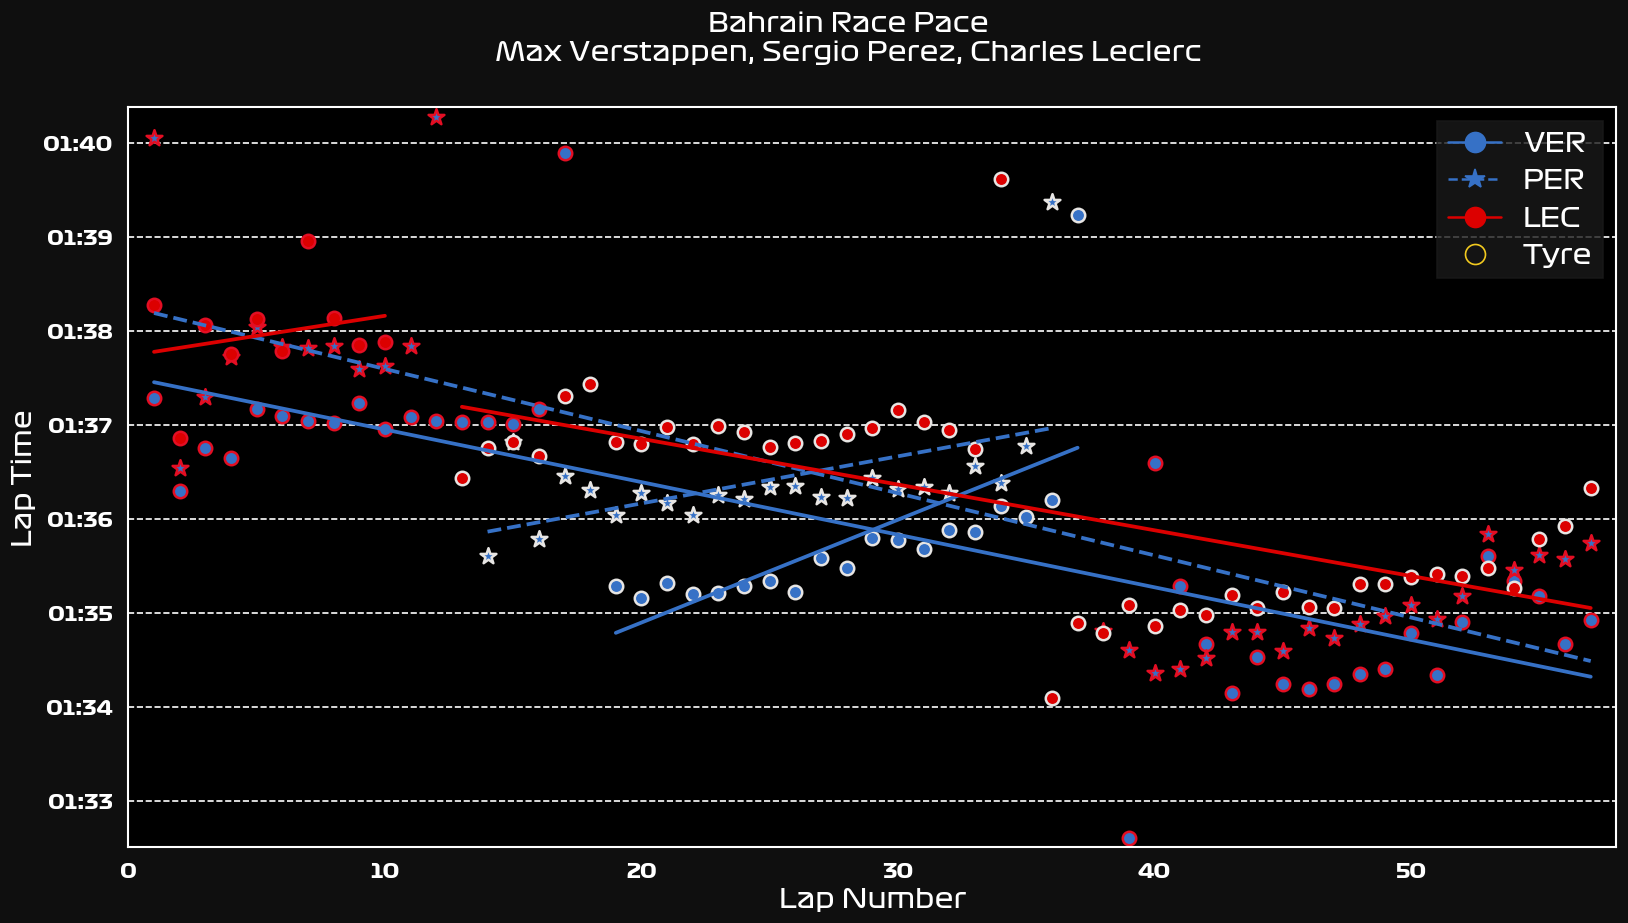

In [5]:
drivers_in_graph = ["VER", "PER", "LEC"]

laptime_scatter_trend(drivers_in_graph)